In [1]:
import numpy as np
import pandas as pd
from os.path import join
from os import listdir
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

import glambox as gb

%load_ext autoreload
%autoreload 2

In [2]:
## Load individual estimates from NHB paper datasets
path = '/Users/felixmolter/Desktop/gaze-bias-differences/results/estimates/in_sample/GLAM/'
files = listdir(path)

parameters = ['v', 'gamma', 's', 'tau']
estimates = []

for file in files:
    subject = int(file.split('_')[1])
    estimates_i = pd.read_csv(path + file, index_col=0)
    df = pd.DataFrame(dict(subject=subject), index=[subject])
    for parameter in parameters:
        df[parameter] = estimates_i.loc[parameter + '__0_0', 'MAP']
    estimates.append(df)

estimates = pd.concat(estimates).sort_values('subject').reset_index(drop=True)
estimates['dataset'] = 39 * ['krajbich2010'] + 30 * ['krajbich2011'] + 24 * ['folke2016'] + 25 * ['tavares2017']

estimates.head(3)

,subject,v,gamma,s,tau,dataset
0,0,0.000084,0.79,0.010750,0.49,krajbich2010
1,1,0.000095,-0.13,0.009213,0.22,krajbich2010
2,2,0.000024,0.82,0.009846,1.17,krajbich2010


# Illustrate individual model estimates from NHB 2019

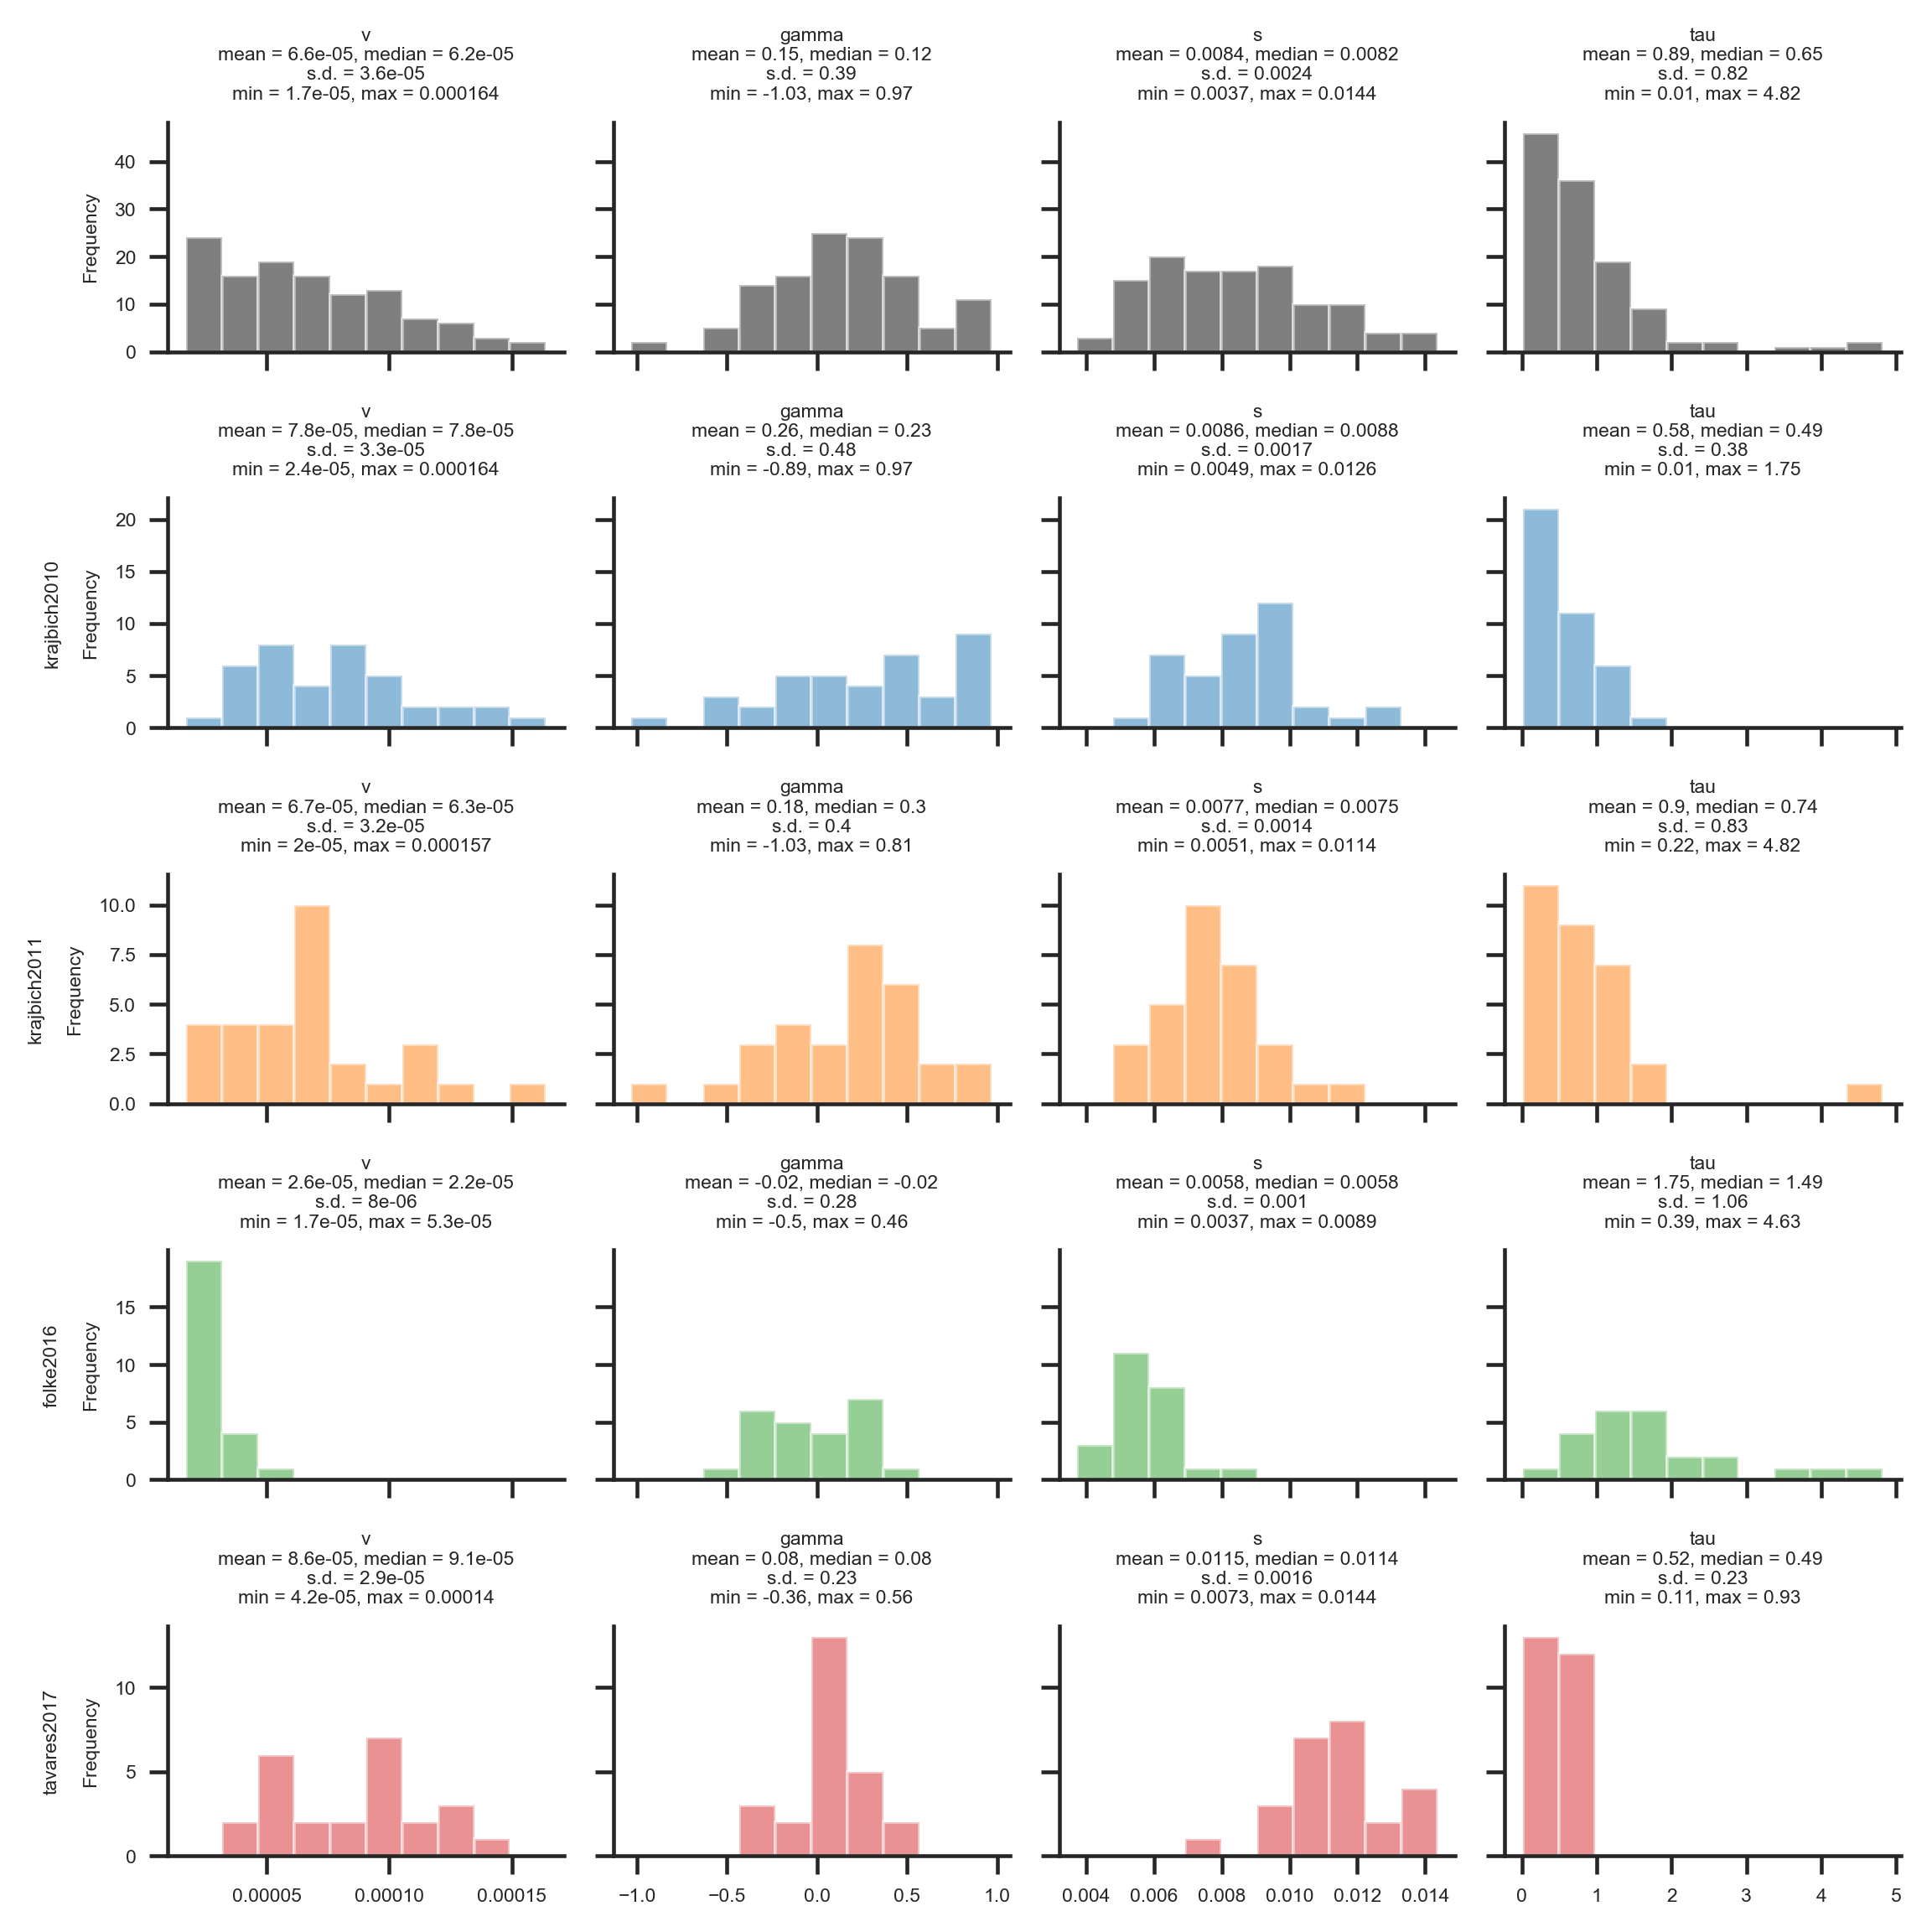

In [3]:
parameters = ['v', 'gamma', 's', 'tau']
fontsize = 5
n_bins = 10

precision = dict(v=6, gamma=2, s=4, tau=2)

datasets = estimates['dataset'].unique()

fig, axs = plt.subplots(len(datasets) + 1,
                        len(parameters),
                        figsize=(gb.plots.cm2inch(18, 18)),
                        dpi=330,
                        sharex='col',
                        sharey='row')

for p, parameter in enumerate(parameters):
    bins = np.linspace(estimates[parameter].min(), estimates[parameter].max(),
                       n_bins + 1)
    mean = np.mean(estimates.loc[:, parameter])
    median = np.percentile(estimates.loc[:, parameter], 50)
    maximum = np.max(estimates.loc[:, parameter])
    minimum = np.min(estimates.loc[:, parameter])
    sd = np.std(estimates.loc[:, parameter])

    axs[0, p].set_title(
        parameter +
        '\nmean = {}, median = {}\ns.d. = {}\nmin = {}, max = {}'.format(*[
            np.round(x, precision[parameter])
            for x in [mean, median, sd, minimum, maximum]
        ]),
        fontsize=fontsize)
    axs[0, p].hist(estimates.loc[:, parameter],
                   bins=bins,
                   color='black',
                   alpha=0.5,
                   edgecolor='white')
    if p == 0:
        axs[0, p].set_ylabel('Frequency', fontsize=fontsize)

    for d, dataset in enumerate(datasets):
        if p == 0:
            axs[d + 1, 0].set_ylabel(dataset + '\n\nFrequency',
                                     fontsize=fontsize)
        axs[d + 1, p].hist(
            estimates.loc[estimates['dataset'] == dataset, parameter],
            alpha=0.5,
            edgecolor='white',
            bins=bins,
            color='C{}'.format(d),
            density=False)

        mean = np.mean(
            estimates.loc[estimates['dataset'] == dataset, parameter])
        median = np.percentile(
            estimates.loc[estimates['dataset'] == dataset, parameter], 50)
        sd = np.std(estimates.loc[estimates['dataset'] == dataset, parameter])
        maximum = np.max(
            estimates.loc[estimates['dataset'] == dataset, parameter])
        minimum = np.min(
            estimates.loc[estimates['dataset'] == dataset, parameter])

        axs[d + 1, p].set_title(
            parameter +
            '\nmean = {}, median = {}\ns.d. = {}\nmin = {}, max = {}'.format(*[
                np.round(x, precision[parameter])
                for x in [mean, median, sd, minimum, maximum]
            ]),
            fontsize=fontsize)

for ax in axs.ravel():
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

fig.tight_layout()
sns.despine()
plt.savefig('si/individual_estimates_nhb2019.png', dpi=330)

# Group level parameter distributions (across datasets)

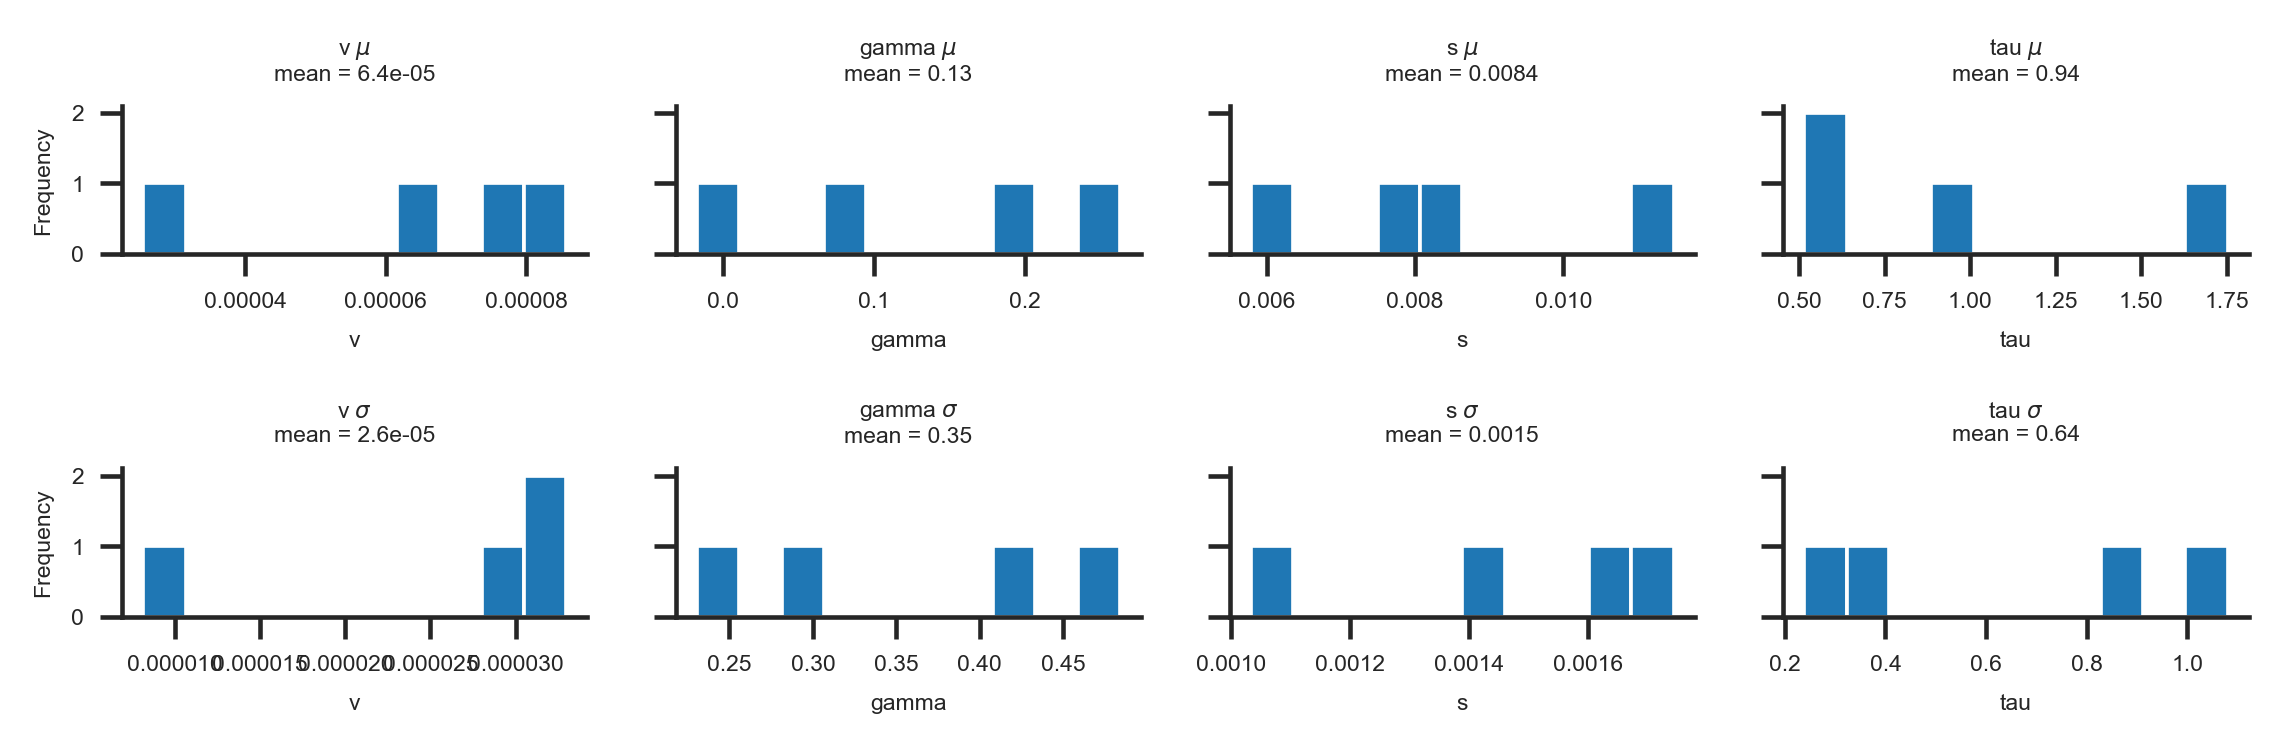

In [4]:
fontsize = 5

n_params = len(parameters)

fig, axs = plt.subplots(2,
                        n_params,
                        figsize=gb.plots.cm2inch(18, 6),
                        dpi=330,
                        sharey='row')

for p, parameter in enumerate(parameters):

    # Mean
    means = estimates.groupby('dataset')[parameter].mean()
    axs[0, p].hist(means)
    axs[0, p].set_title(
        parameter + r' $\mu$' +
        '\nmean = {}'.format(np.round(np.mean(means), precision[parameter])),
        fontsize=fontsize)
    axs[0, p].set_xlabel(parameter,
                         fontsize=fontsize)
    if p == 0:
        axs[0, p].set_ylabel('Frequency',
                             fontsize=fontsize)

    # SD
    sds = estimates.groupby('dataset')[parameter].std()
    axs[1, p].hist(sds)
    axs[1, p].set_title(
        parameter + r' $\sigma$' +
        '\nmean = {}'.format(np.round(np.mean(sds), precision[parameter])),
        fontsize=fontsize)
    axs[1, p].set_xlabel(parameter,
                         fontsize=fontsize)
    if p == 0:
        axs[1, p].set_ylabel('Frequency',
                             fontsize=fontsize)
for ax in axs.ravel():
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

sns.despine()
fig.tight_layout()

The group level distributions of parameters across datasets are very uninformative. There's no indication of a central tendency.

# Visualize (hyper)priors implemented in the model

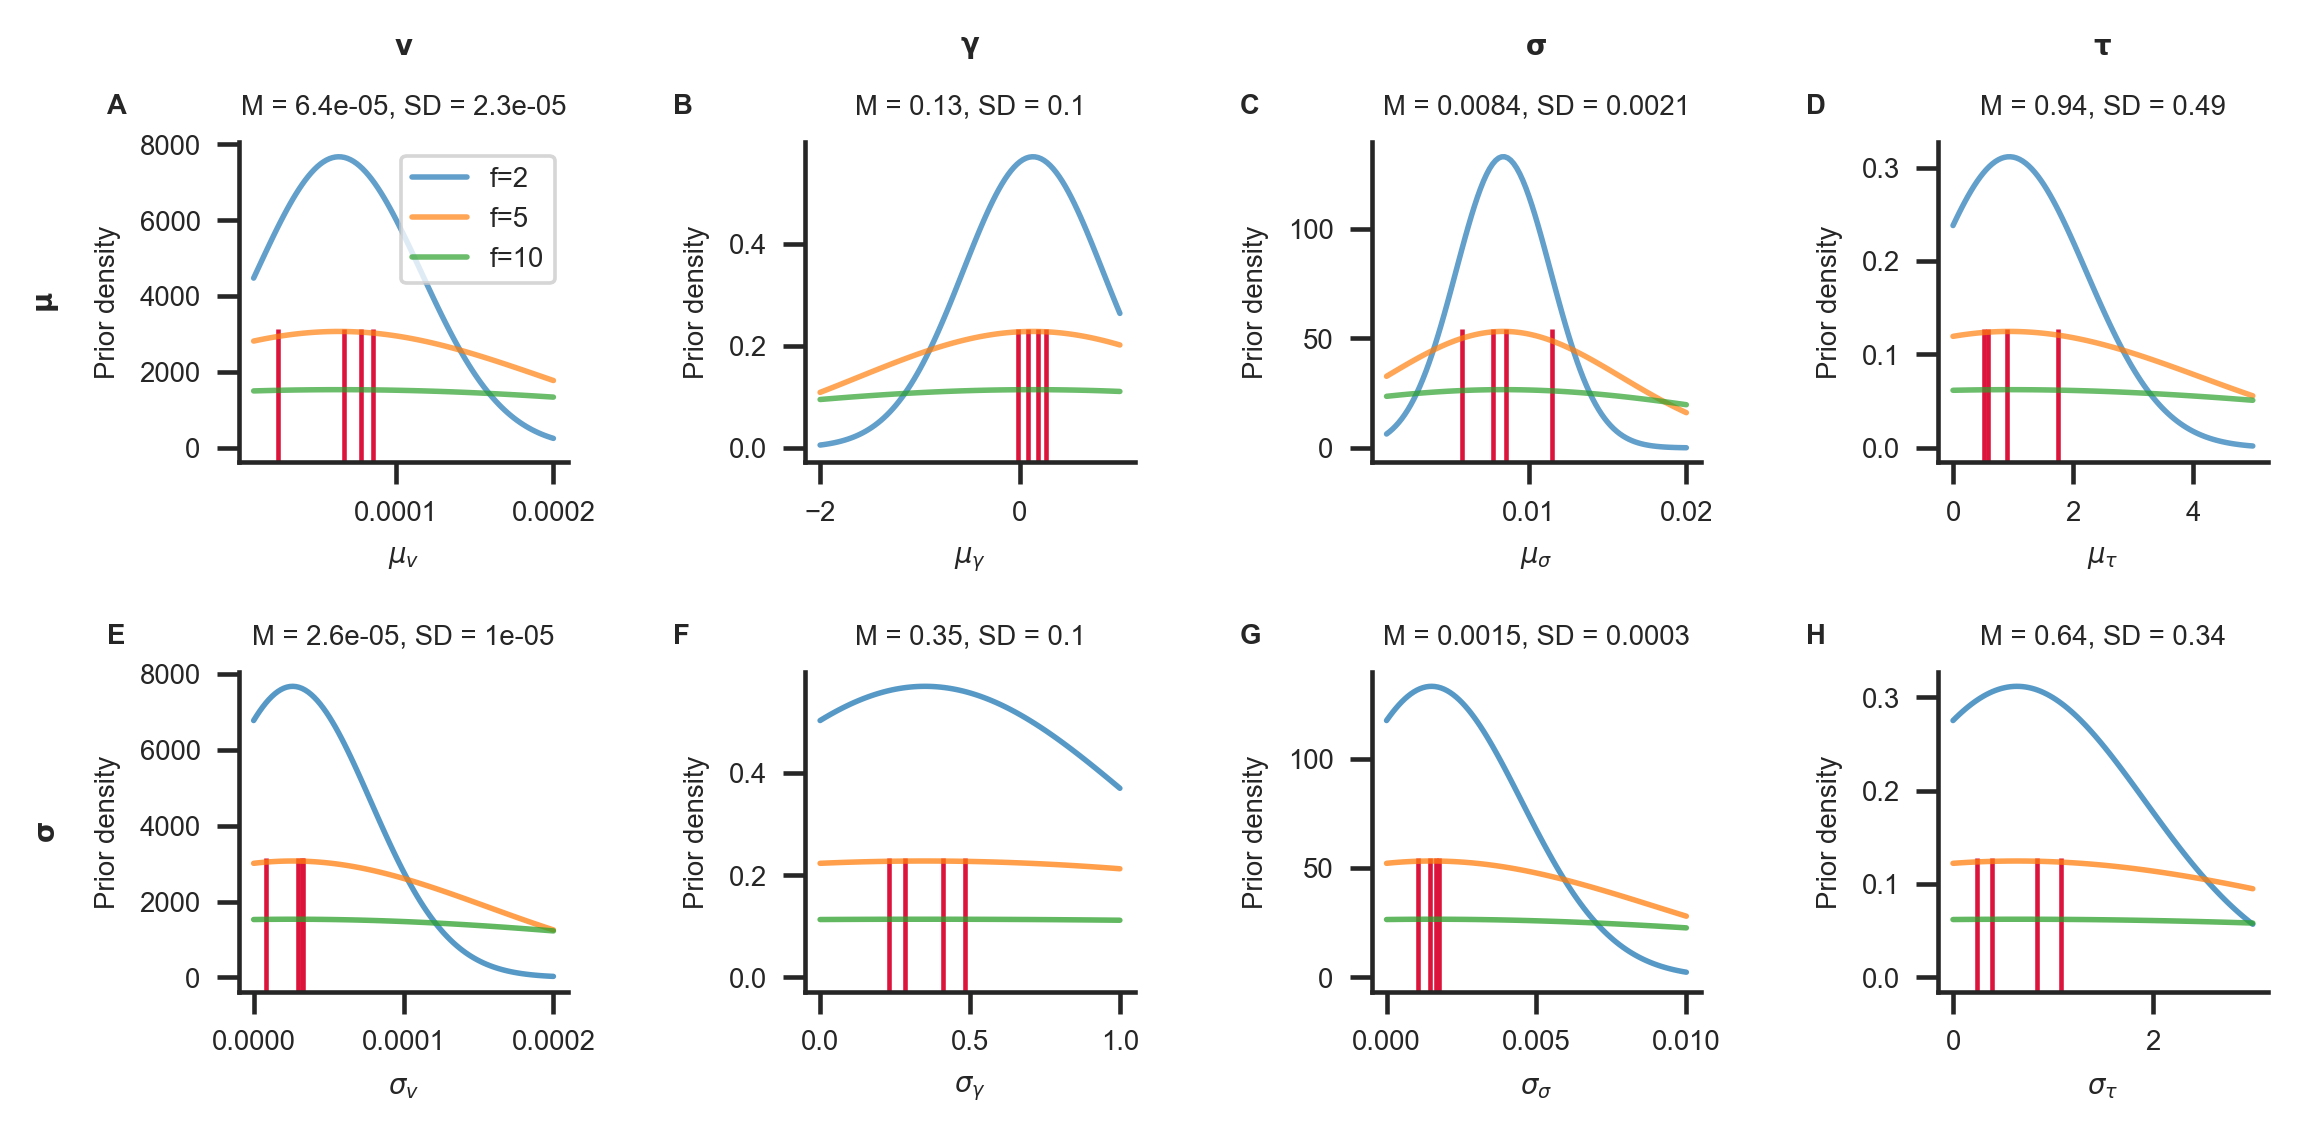

In [5]:
fontsize = 6
fs = [2, 5, 10]

parameters = ['v', 'gamma', 's', 'tau']
parameter_labels = dict(v='v', gamma='\gamma', s='\sigma', tau='\\tau')

from scipy.stats import norm

n_params = len(parameters)

fig, axs = plt.subplots(2, n_params, figsize=gb.plots.cm2inch(18, 9), dpi=330)

for p, parameter in enumerate(parameters):

    # Observed
    ## Mean
    means = estimates.groupby('dataset')[parameter].mean()
    axs[0, p].plot(means,
                   np.zeros(len(means)),
                   '|',
                   color='crimson',
                   markersize=52)
    axs[0, p].set_title(r'$\bf{{{p}}}$'.format(p=parameter_labels[parameter]) +
                        '\n\nM = {}, SD = {}'.format(
                            np.round(np.mean(means), precision[parameter]),
                            np.round(np.std(means), precision[parameter])),
                        fontsize=fontsize)
    axs[0, p].set_xlabel(r'$\mu_{}$'.format(parameter_labels[parameter]),
                         fontsize=fontsize)
    if p == 0:
        axs[0, p].set_ylabel(r'$\bf{\mu}$' + '\n\nPrior density',
                             fontsize=fontsize)
    else:
        axs[0, p].set_ylabel('Prior density', fontsize=fontsize)

    ## SD
    sds = estimates.groupby('dataset')[parameter].std()
    axs[1, p].plot(sds,
                   np.zeros(len(sds)),
                   '|',
                   color='crimson',
                   markersize=52)
    axs[1, p].set_title('\n\nM = {}, SD = {}'.format(
        np.round(np.mean(sds), precision[parameter]),
        np.round(np.std(sds), precision[parameter])),
                        fontsize=fontsize)

    axs[1, p].set_xlabel(r'$\sigma_{}$'.format(parameter_labels[parameter]),
                         fontsize=fontsize)
    if p == 0:
        axs[1, p].set_ylabel(r'$\bf{\sigma}$' + '\n\nPrior density',
                             fontsize=fontsize)
    else:
        axs[1, p].set_ylabel('Prior density', fontsize=fontsize)

    # New Priors
    for i, f in enumerate(fs):
        v_mu = dict(mu=6.4e-5, sd=f * 2.6e-5, lower=1e-5, upper=0.0002)
        v_sd = dict(mu=2.6e-5, sd=f * 2.6e-5, lower=0, upper=0.0002)

        gamma_mu = dict(mu=0.13, sd=f * 0.35, lower=-2, upper=1)
        gamma_sd = dict(mu=0.35, sd=f * 0.35, lower=0, upper=1)

        s_mu = dict(mu=0.0084, sd=f * 0.0015, lower=0.001, upper=0.02)
        s_sd = dict(mu=0.0015, sd=f * 0.0015, lower=0, upper=0.01)

        tau_mu = dict(mu=0.94, sd=f * 0.64, lower=0, upper=5)
        tau_sd = dict(mu=0.64, sd=f * 0.64, lower=0, upper=3)

        mu = dict(v=v_mu, gamma=gamma_mu, s=s_mu, tau=tau_mu)

        sd = dict(v=v_sd, gamma=gamma_sd, s=s_sd, tau=tau_sd)
        x_mu = np.linspace(mu[parameter]['lower'], mu[parameter]['upper'], 100)
        axs[0, p].plot(x_mu,
                       norm.pdf(x_mu,
                                loc=mu[parameter]['mu'],
                                scale=mu[parameter]['sd']),
                       color='C{}'.format(i),
                       alpha=0.7,
                       label='f={}'.format(f))
        x_sd = np.linspace(sd[parameter]['lower'], sd[parameter]['upper'], 100)
        axs[1, p].plot(x_sd,
                       norm.pdf(x_sd,
                                loc=sd[parameter]['mu'],
                                scale=sd[parameter]['sd']),
                       color='C{}'.format(i),
                       alpha=0.75,
                       label='f={}'.format(f))

# Legend
axs[0, 0].legend(fontsize=fontsize)
        
# Panel Labels
from string import ascii_uppercase
for label, ax in zip(list(ascii_uppercase), axs.ravel()):
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.text(-0.4,
            1.15,
            label,
            transform=ax.transAxes,
            fontsize=fontsize,
            fontweight='bold',
            va='top')

for ax in axs.ravel():
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

sns.despine()
fig.tight_layout(h_pad=-0.2, w_pad=1.2)
plt.savefig(join('si', 'hyperpriors.png'), dpi=330)